# TFM Máster Data Science UAH 2020-2021

### MIGUEL PÉREZ CARO

Este notebook tiene como objetivo la búsqueda de patrones. Para ello, se llevarán a cabo dos fases diferenciadas. Una primera que consiste en la conversión del texto, una vez limpiado, a vector, con diferentes técnicas como:

- BOW y TFIDF
- Modelos preentrenados de spacy o gensim
- Modelo Word2Vec o Doc2Vec
- Modelo BERT

Una vez el texto se ha convertido a vector, se puede comenzar con la segunda parte del notebook que consiste con la búsqueda de los patrones con diferentes técnicas como:

- Búsqueda de topics
- Visualización tras reducción de dimensionalidad
- Clusterización por K-Means

En primer lugar se importan las librerías

In [1]:
import os
import re
import umap
import torch
import spacy
import string
import gensim
import pickle
import pyLDAvis
import warnings
import numpy as np
import pandas as pd
import altair as alt
import pyLDAvis.gensim
import transformers as ppb
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from gensim.matutils import corpus2dense
from gensim.models import CoherenceModel
from gensim.test.utils import get_tmpfile
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

warnings.filterwarnings("ignore")

Se genera una semilla para que los resultados sean reproducibles

In [2]:
name = 'Miguel Pérez'
seed = sum(ord(s) for s in name)

Se establece el directorio del archivo

In [3]:
directorio = os.path.dirname(os.getcwd())
mydir = os.path.join(directorio, 'data')
os.chdir(mydir)

Se carga el archivo

In [4]:
df = pd.read_csv('df_clean_no_dup.csv')

Se eliminan las columnas id, created_at, retweet_count y favorite_count ya que no son necesarias para el análisis

In [5]:
df.drop(columns=['id', 'created_at', 'retweet_count', 'favorite_count'], inplace = True)

Se elimina todo documento que contenga menos de 5 términos al considerar que no contiene información necesaria para poder encontrar un topic o un patrón.

In [6]:
df = df[df['text'].apply(lambda x: len(x.split(' ')) > 4)]
df.reset_index(drop=True, inplace=True)

In [7]:
df.sample(5)

,text,southwest,american,united,delta
62048,get compliment jennifer mia airport check fab ...,0.0,1.0,0.0,0.0
106078,loved youd care insider trading united stock p...,0.0,1.0,1.0,0.0
97563,know u take precautions folks cabin worry im c...,1.0,0.0,0.0,0.0
95118,john mulaney known loving wife john mulaney kn...,0.0,0.0,0.0,1.0
109038,mask allow drink without taking mask deltaairl...,0.0,0.0,0.0,1.0


A continuación se lleva a cabo el análisis de sentimiento de cada tweet ya que puede ser de utilidad en posteriores análisis.

In [8]:
vader_analyzer = SentimentIntensityAnalyzer()

In [9]:
def vader_sentiment_analysis(text):
    """
    Función para calcular el sentimiento de los tweets a partir de la librería VADER.
    
    param: text texto a calcular su sentimiento.
    :return: vader_sentiment resultado compound del análisis.
    """
    vader_sentiment_full = vader_analyzer.polarity_scores(text)
    vader_sentiment = vader_sentiment_full['compound']
    return vader_sentiment

In [10]:
def vader_sentiment_texto(score): 
    """
    Función para pasar a texto el resultado del análisis de sentimiento.
    
    param: score el resultado del análisis.
    :return: Valor en texto del resultado
    """
    if score < -0.05:
        return 'Negativo'
    elif score > 0.05:
        return 'Positivo'
    else:
        return 'Neutral'

In [11]:
df['vader-sentiment'] = df['text'].apply(vader_sentiment_analysis)
df['vader-sentiment-analysis'] = df['vader-sentiment'].apply(vader_sentiment_texto)

### Conversión a Vector

#### BOW

Este es un modelo conocido como bolsa de palabras que interpreta un documento como un conjunto de palabras, ignorando el orden de estas, por lo que cada texto se convertirá a un vector que consistirá en el número de veces que aparace cada palabra.

El primer paso es crear una lista tokenizada por cada documento del que disponemos.

In [18]:
corpus = [text.split() for text in df['text'].to_list()]

A continuación, generamos un diccionario a partir de nuestro set de datos, filtrando los extremos, lo cuál se consigue con los siguientes parámetros:

- no_below: número de docs a partir del cual se tienen en cuenta la palabra. Valor abs
- no_above: número máximo de documentos en el que puede aparacer la palabra. Es un ratio.

In [19]:
dictionary = gensim.corpora.Dictionary(corpus)
dictionary.filter_extremes(no_below=2, no_above=0.7) 

Se genera la bolsa de palabras

In [20]:
bow_corpus = [dictionary.doc2bow(token_list) for token_list in corpus] 

#### TFIDF

**Dada la dimensión de la matriz resultante, hace muy difícil su uso en las técnicas de búsqueda de topics y clústers, por lo que se obviará más adelante**

TF-IDF son las siglas de Term Frequency - Inverse Document Frquency, que es una medida numérica que muestra lo importante que es un términa para un documento dentro de un set de datos. El término TF crece a medida que la palabra aparece con más frecuencia, mientras que el término IDF aumenta con la rareza de la palabra. Esto está destinado a ajustar las puntuaciones de frecuencia por el hecho de que algunas palabras aparecen con más (o menos) frecuencia en general. Es un método muy sencillo y útil para aplicar posteriormente algoritmos de machine learning, pero cuenta con la desventaja de que descarta el orden de las palabras, ignorando el contexto y, a su vez, el significado de las palabras en el documento lo que puede resultar en una matriz muy dispersa llena de ceros que consuma memoria de forma ineficiente.

Se puede calcular a partir de un modelo de bolsa de palabras. Se va a generar a partir de uno nuevo ya que se pretende hacer un filtro mayor para reducir el tamaño de la matriz resultante.

In [33]:
corpus_tfidf = [text.split() for text in df['text'].to_list()]
dictionary_tfidf = gensim.corpora.Dictionary(corpus_tfidf)
dictionary_tfidf.filter_extremes(no_below=100, no_above=0.5) 
bow_corpus_tfidf = [dictionary_tfidf.doc2bow(token_list) for token_list in corpus_tfidf] 

In [34]:
tfidf = gensim.models.TfidfModel(bow_corpus_tfidf)
tfidf_docs = tfidf[bow_corpus_tfidf]

Como se ha generado una matriz de vectores dispera, que guarda únicamente las posiciones y los valores de los elementos distintos a cero, se ha de usar el método `corpus2dense` que convierte una matriz dispersa a una matriz densa.

In [35]:
num_docs = dictionary_tfidf.num_docs
num_terms = len(dictionary_tfidf.keys())
tfidf_corpus = corpus2dense(tfidf_docs, num_terms, num_docs)

In [37]:
tfidf_corpus = tfidf_corpus.T

#### Modelo Preentrenado

Los modelos preentrenados son una técnica muy útil para el análisis de documentos. Un modelo pre-entrenado es una colección de embeddings que han sido ya creados, y que solo hay que descargarse. De esta forma, se tiene acceso a un modelo entrenado con una cantidad masiva de datos a la que de otra forma no se tendría acceso. Ejemplos de estos modelos incluyen toda la Wikipedia o todas las noticias de Google. Esto permite hacer uso de todo ese dato sin necesidad de procesarlo porque ya hay un modelo entrenado. La desventaja es que el corpus contenido puede no captar ciertas peculiaridades del conjunto de datos con el que se está trabajando. Se comentan a continuación dos formas de obtener modelos preentrenados:

- Spacy: librería que provee de diferentes modelos pre-entrenados, diseñada para un rendimiento rápido. Es perfecta para análisis sencillos y de poca duración. Además esta librería contiene modelos en 7 idiomas diferentes y de diferentes tamaños para adaptarse a las necesidades de cada usuario, incluyendo modelos con más de 20 mil vectores únicos de 300 dimensiones.

- Gensim: esta librería muy utilizada para procesamiento de lenguaje natural no incluye modelos pre-entrenados como en el caso de spacy, pero si que hay una forma muy sencilla de encontrarlos y descargarlos a través de esta librería. Un modelo pre-entrenado muy popular es el Google News dataset model, que contiene embeddings de 300 dimensions para más de 3 millones de palabras y frases.

Debido al hecho de que gensim no trae consigo los modelos, mientras que spacy sí lo hace, siendo una librería muy fiable y rápida de usar, se opta por esta librería para usar un modelo preentrenado.

El primer paso es descargar el modelo en el entorno, y una vez hecho, se puede cargar:

In [36]:
spacy_model = spacy.load('en_core_web_lg')

A continuación hay que pasar todos los documentos por el modelo que se acaba de cargar para poder convertirlos a un vector posteriormente.

In [18]:
spacy_corpus_model = [spacy_model(tweet['text']) for _, tweet in df.iterrows()]

In [19]:
spacy_corpus = np.zeros((len(spacy_corpus_model), 300))
for idx, tweet in enumerate(spacy_corpus_model):
    spacy_corpus[idx, :] = tweet.vector
    
spacy_corpus.shape

(201808, 300)

Se guarda para poder hacer uso del fichero más adelante sin necesidad de crearlo nuevamente.

In [62]:
np.savetxt('spacy_corpus.csv', spacy_corpus, delimiter = ',')

#### Doc2Vec

Doc2vec es la extensión de word2vec a embeddings de documentos. Word2vec es un algoritmo que incrusta palabras en un espacio vectorial de menor dimensión haciendo uso de una red neuronal poco profunda. El resultado es un conjunto de vectores de palabras donde los vectores cercanos en el espacio vectorial tienen significados similares basados en el contexto, y los vectores de palabras distantes entre sí tienen significados diferentes. El problema es que el modelo Word2vec solo calcula vectores por palabras, y de ahí que se haya generado el modelo doc2vec o paragraph vector, que generalmente supera el resultado de hacer un simple promedio de los vectores word2vec. El principal problema de este algoritmo puede que sea el rendimiento, ya que todos los vectores son almacenados en la RAM, lo que puede hacer que el uso de la memoria crezca linealmente con el tamaño del corpus, causando problemas en el rendimiento del ordenador.

Para poder entrenar un modelo es necesario añadir un identificador a cada documento, que será simplemente el número de fila en el dataframe de cada documento.

In [20]:
doc2vec_corpus = [' '.join(word for word in text) for text in corpus]

In [21]:
tagged_data = [TaggedDocument(words=word_tokenize(_d), tags=[str(i)]) for i, _d in enumerate(doc2vec_corpus)]
tagged_data[0]

TaggedDocument(words=['aaaa', 'literally', 'screamed', 'loud', 'noticed', 'replied', 'lol'], tags=['0'])

A continuación se genera el modelo doc2vec:

- dm = 0. Para el contexto que nos ocupa, es decir, similitud de documentos, se ha de escoger el modelo PV-DBOW, que el valor por defecto.
- vector_size = 50. Tamaño del vector. 50 es un valor razonable.
- min_count = 5. Mínimo número de veces que una palabra tiene que aparecer en el corpus para ser incluida.
- epochs = 40. Número de iteraciones. Para decenas de miles de documentos entre 10 y 20 iteraciones es lo recomendable, por lo que para este caso, con 5936 documentos, 40 es una buena aproximación.

In [22]:
# Generar modelo
model = Doc2Vec(vector_size=50, min_count=5, epochs=40, seed = seed)

# Construir el vocabulario
model.build_vocab(tagged_data)

# Entrenar el modelo
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

Se guarda el modelo

In [23]:
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [24]:
model.save('./models/doc2vec_model.mod')

In [25]:
# Cargar el modelo
# model = Doc2Vec.load('./models/my_doc2vec_model.mod')

Se generan los documentos

In [26]:
doc2vec_corpus = list()
for doc_id in range(len(tagged_data)):
    # Se genera el nuevo vector por documento
    inferred_vector = model.infer_vector(tagged_data[doc_id].words)
    doc2vec_corpus.append([inferred_vector])

In [59]:
doc2vec_corpus = np.concatenate(doc2vec_corpus, axis = 0)

Se guarda para poder hacer uso del fichero más adelante sin necesidad de crearlo nuevamente.

In [60]:
np.savetxt('doc2vec_corpus.csv', doc2vec_corpus, delimiter = ',')

#### BERT

Debido a la alta capacidad computacional requerida para hacer uso del modelo BERT, se ha recurrido a un notebook en Google Colab en el que se ejecutan estas mismas celdas y se guarda el array con los embeddings por lo que a continuación se explica lo realizado y se comentan todas las celdas para no ejecutarlas, y únicamente se carga el csv generado.

BERT son las siglas de Bidirectional Encoder Representations from Transformers. BERT es un modelo de procesamiento de lenguaje natural que aplica dos ténicas que en su diseño fueron novedosas y mejoraban los algoritmos con los que se estaba trabajando. BERT aplica un entrenamiento bidireccional de transformadores, que contrasta con las técnicas previas de leer el texto de derecha a izquiera, de izquierda a derecha o en ambas. Esta técnica ayuda a captar mucho mejor el contexto de las frases. Para ello, el modelo ha sido entrenado con un corpus sin clasificar de grandes dimensiones que incluye, entre otros, toda la Wikipedia y multitud de libros. BERT puede ser aplicado a muchas tareas de procesamiento de lenguaje natural ya que permiite adaptar este modelo preentrenado, haciendo uso de todo lo aprendido,y modificarlo para lo que el usuario necesite.


El primer paso es obtener los modelos de BERT


In [27]:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Cargar model/tokenizer
#tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
#model = model_class.from_pretrained(pretrained_weights)

Tokenizar el texto

In [28]:
#tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Ahora se dispone de una lista que contiene cada documento como lista de tokens, cada uno de una dimensión determinada. El objetivo es procesar todos los documentos con BERT. Para ello, necesitamos representar las listas como un array 2D, lo que conlleva que todas las listas tengan la misma dimensión:

In [29]:
# Obtener lista más larga
#max_len = len(max(tokenized, key=len))

# Generar el array
#array_tokenized = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

Ahora mismo cada fila del array se corresponde con la lista de tokens de cada documentos, más una serie de 0 hasta llegar a la misma dimensión que el documento tokenizado más largo. Obviamente, esta serie de ceros puede confundir al modelo, por lo que habrá que crear otra variable que indique al modelo que ignore dichos ceros. Dicha variable consisterá en un array de las mismas dimensiones de forma que por cada documento, se van a añadir tantos 1 como tokens haya en el documento, rellenando con 0 hasta la dimensión necesaria, de forma que los 1 indicarán al modelo que en esa posición hay un token del documento, y los 0 indicarán que ese contenido del array se puede obviar.

In [30]:
#attention_mask = np.where(array_tokenized != 0, 1, 0)
#attention_mask.shape

Con el array tokenizado y la variable que se acaba de generar, se puede ejecutar el modelo

In [31]:
#array_tokenized_input = torch.tensor(array_tokenized)  
#attention_mask = torch.tensor(attention_mask)

#with torch.no_grad():
#    bert_corpus_full = model(array_tokenized_input, attention_mask=attention_mask)

El resultado es un tensor de 3 dimensiones de forma que en un eje tridimensional clásico, el eje y marcaría el número de documentos, el eje x tendría una dimensión igual a la longitud máxima de los documentos calculada anteiormente, y el eje z se corresponde con las capas ocultas generadas por el modelo BERT que son un total de 768. El primer token de cada fila es el que se denomina CLS token y es el referido para clasificación, que es el que nos interesa, de esta forma, podemos obtener un vector por cada documento compuesto por el CLS token de cada capa oculta generada por BERT.

In [32]:
#bert_corpus = bert_corpus_full[0][:,0,:].numpy()

In [33]:
bert_corpus = np.loadtxt('./data/bert_corpus.csv', delimiter = ',')

In [34]:
bert_corpus.shape

(201808, 768)

### Búsqueda Patrones

#### TOPICS

Para la búsqueda de topics se va a aplicar el modelo Latent Dirichlet Alocation, propuesto en 2003 por David Blei, Andrew Ng y Michael Jordan, siendo un modelo generativo que presupone que los documentos estan compuestos por una distribución de topics, y cada topic compuesto por una distribución de palabras. Así, conociendo estas distribuciones podríamos generar los documentos de un corpus, u otros similares.

Entre las cuestiones técnicas, cabe destacar que este modelo se basa en los modelos de bolsa de palabras, generalmente sin aplicar normalizaciones sobre los mismos, por lo que el orden de las palabras no se tiene en cuenta.

Un aspecto importante de los modelos LDA es la dificultad de encontrar el número óptimo de topics, ya que este es uno de los parámetros del modelo. Para ello, se busca una forma empírica para averiguar el número óptimo.

Una métrica que se puede obtener de estos topics es el coherence topic, que mide para cada topic el grado de similitud semántica entre las palabras de puntuación alta en dicho topic. Esta métrica ayuda a distinguir entre topics que son semánticamente interpretables y topics que son artefactos de inferencia estadística y no nos ayudan a entender mejor los datos.

Para ello, se genera una función que calcula el coherence topic para cada modelo.

In [35]:
def coherence_topic(id2word, corpus, texts, limit, start, seed):
    """
    Función que genera el coherence topic de un modelo LDA
    param: id2word diccionario de gensim
    param: corpus modelo de bolsa de palabras
    param: texts matriz con la lista de palabras de cada documento. Es la matriz con la que se genera el diccionario.
    param: limit máximo número de topics
    param: start mínimo número de topics
    param: seed semilla escogida para el notebook
    
    :return: model_list lista de los topics de los modelos LDA
    :return: coherence_values lista con los valores del coherence topic de cada modelo LDA
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, 2):
        model_lda = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=seed) # Generar el modelo
        model_list.append(model_lda) 
        coherence_model_lda = CoherenceModel(model=model_lda, texts=texts, dictionary=id2word, coherence='c_v') # Generar el coherence topic
        coherence_values.append(coherence_model_lda.get_coherence())
    return model_list, coherence_values

In [36]:
model_list, coherence_values = coherence_topic(dictionary, bow_corpus, corpus, 31, 2, seed)

A continuación se visualizan los resultados obtenidos con el objetivo de encontrar el número óptimo de topics.

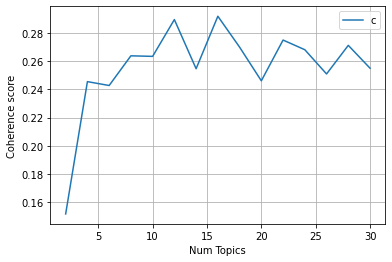

In [37]:
x = range(2,31,2)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()

Se puede apreciar una línea ascendente hasta los 12 topics donde comienza una variación constante de los valores. Parece que losmodelos de 12 y 16 topics son los que han obtenido un coherence score superior, por lo que se va a optar por el de 12 topics ya que se considera un número suficiente de topics y. no es necesario aumentarlo.

A continuación se genera el modelo de 12 topics:

In [38]:
model_lda_12 = gensim.models.LdaModel(corpus=bow_corpus, num_topics=12, id2word=dictionary, random_state=seed)

Se guarda el modelo

In [39]:
model_lda_12.save('./models/lda_model.mod')

Para examinar el modelo generado, una buena herramienta se encuentra en el paquete pyLDAvis que nos permite generar un gráfico interactivo dentro de jupyter notebook para analizar los topics.

In [40]:
pyLDAvis.enable_notebook(local=True)
vis = pyLDAvis.gensim.prepare(model_lda_12, bow_corpus, dictionary=dictionary)
pyLDAvis.save_html(vis, 'lda-analysis.html')
pyLDAvis.display(vis)

En el gráfico interactivo que se ha generado en la celda anterior, cada burbuja del lado izquiero del gráfico representa un topic. Cuanto más grande es la burbuja, más frecuente es ese tema. Los topics más claros son aquellos que no se encuentran superpuestos, pero al ser un modelo con una cantidad de topics alta es normal que se superpongan. Moviendo el cursor por las burbujas se puede comprobar las palabras que componen ese topic, así como la frecuencia de cada palabra en el total de documentos y en los documentos del topic. Analizando los diferentes topics se pueden extraer una serie de conclusiones:

- El topic 1 incluye todo lo relacionado con los vuelos ya que la palabra principal es "flight", por lo que es un topic muy importante. A su vez, incluye otro tipo de palabras como "delayed" o "canceled" que son muy importantes para una aerolínea, y podrían mostrar una queja de los usuarios, lo cuál tiene bastante sentido, ya que el topic 1 se superpone con el topic 2, que incluye los términos "customer" y "service", por lo que, aunque se agrupen en topics diferentes, se ve que están claramente relacionados, y son tweets a los que la aerolínea debería prestar especial atención.


- Por otro lado se encuentra el topic 5 que incluye palabra de agradecimiento como "thanks" u otros términos que demuestran positividad como "love" o "great", por lo que es claramente un topic que aglutina tweets con un sentimiento positivo.


- En el topic 11 destacan 2 palabras que son "weather" y "issues" lo cuál puede evidenciar que un tema principal de este topic son aquellos tweets que mencionan problemas derivados del clima.


- Un tema que también se esperaba que apareciese es el de las vacunas, y ocurre en el topic 4, donde se menciona mucho las palabras "vaccine" y "vaccinated" así como "airlines" y "employees", lo que claramente trata sobre la política de vacunación de la aerolínea, las vacunas a los empleados, etc.

- Por último, en el topic 6 podemos encontrar términos como "luggage", "bag", "bags" o "lost", lo cuál parece indicar que hace referencia a las quejas sobre maletas o bolsas de equipaje extraviadas, y que nuevamente evidencia un problema en los serivios de la aerolínea

Una vez analizado los topics más destacados, también interesa conoce a que topic pertenece cada documento. Es por ello que es necesario mencionar que, aunque el anterior gráfico es realmente útil para analizar los topics, el número asignado a cada uno de ellos, que podemos considerar como su identificador, es diferente al devuelto por la función show_topics, método del modelo lda, por lo que habrá que identificarlos en base a las keywords.

En primer lugar, se genera un dataframe con el texto, el topic dominante del documento, la contribución del mismo, ya que cada documento es una combinación de topics de forma que la suma de las probablidades de todos los topics que forman un documento es igual a 1, y las keywords del topic dominante.

In [41]:
def topic_document(ldamodel, corpus, data):
    """
    Función que asigna a cada documento el topic dominante.
    
    param: ldamodel el modelo de 12 topics.
    param: corpus modelo de bolsa de palabras.
    param: data es el conjunto de datos.
    
    :return: dataframe con el topic dominante, las palabras clave y el texto de cada documento.
    """
    
    # Se genera un dataframe vacío
    sent_topics_df = pd.DataFrame()

    # Se obtiene el topic principal para cada documento
    for i, row in enumerate(ldamodel[corpus]):     
        # Se obtiene una lista ordenada de los topics presentes en un documento de mayor a menor importancia
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # A partir de la lista anterior, se obtiene el topic dominante, su importancia en el texto, y sus palabras claves
        for j, (topic_num, prob_topic) in enumerate(row):
            if j == 0:  # el primer topic es el dominante
                # Se obtienen las palabras clave
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                
                # Se añaden los resultados al dataframe
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prob_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

    # Se concatenan los documentos con el dataframe que contiene los topics
    contents = pd.DataFrame(data)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1, ignore_index = False, join="outer")
    
    # Se nombran las columnas
    sent_topics_df.columns = ['main-topic', 'score-main-topic', 'keywords-topic', 'text']
    return(sent_topics_df)

In [42]:
df_topics = topic_document(model_lda_12, bow_corpus, df.text)

/opt/anaconda3/envs/master/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/master/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/master/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/master/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/master/lib/python3.7/site-packages/past/builtins/misc.py

In [43]:
df_full_topics = pd.merge(df, df_topics, on='text')

In [44]:
df_full_topics.sample(5)

,text,southwest,american,united,delta,vader-sentiment,vader-sentiment-analysis,main-topic,score-main-topic,keywords-topic
192616,worried travel industry rest assured things co...,0.0,0.0,0.0,1.0,0.0772,Positivo,1.0,0.3040,"dont, want, know, like, yo, get, work, think, ..."
98955,late kick lady loud obnoxious dog plane flightaa,0.0,1.0,0.0,0.0,-0.4588,Negativo,3.0,0.2977,"travel, first, youve, business, class, flights..."
59389,found hidden tiny screen sad,0.0,0.0,0.0,1.0,-0.4767,Negativo,9.0,0.2168,"year, mask, old, thing, youre, right, san, the..."
4127,airlines flying dfw canceled flight twice,0.0,1.0,0.0,0.0,0.0000,Neutral,2.0,0.4852,"flight, get, hours, delayed, trying, yall, fli..."
163160,thank didnt hours advance one ever given p,1.0,0.0,0.0,0.0,0.3612,Positivo,5.0,0.3572,"good, us, flights, weather, dm, issues, theres..."


In [45]:
topic_sentiment = df_full_topics.groupby('main-topic').agg({'vader-sentiment': 'mean',
                                                          'keywords-topic': 'first'}).reset_index()
topic_sentiment

,main-topic,vader-sentiment,keywords-topic
0,0.0,0.003538,"service, yeah, customer, worst, hours, call, e..."
1,1.0,0.049357,"dont, want, know, like, yo, get, work, think, ..."
2,2.0,0.020826,"flight, get, hours, delayed, trying, yall, fli..."
3,3.0,0.088112,"travel, first, youve, business, class, flights..."
4,4.0,0.138008,"face, joy, tears, last, u, sitting, tell, upda..."
5,5.0,0.115011,"good, us, flights, weather, dm, issues, theres..."
6,6.0,0.333140,"thanks, youre, thank, would, love, great, unit..."
7,7.0,0.120568,"us, wow, face, airlines, employees, cheap, cov..."
8,8.0,0.094483,"yall, would, people, check, sure, make, bag, y..."
9,9.0,0.013189,"year, mask, old, thing, youre, right, san, the..."


Se puede comprobar como los mencionados topic 1 y topic 2 en la ilustración pyLDAvis se corresponden con los topic 2 y 0 de la tabla anterior que son de los que tienen un peor sentimiento, aldo que se había comentado en base a las keywords que componían los topics. Con esa misma premisa, también s epuede combrobar que el topic 5 anterior es el topic 6 de la tabla que es el que tiene un sentimiento más positivvo con una gran diferencia, lo que evidencia que es el que aglutina más tweets positivos.

#### REDUCCIÓN DE DIMENSIONALIDAD

Mediante la reducción de dimensionalidad no lineal se puede obtener una aproximación a un espacio de baja dimensionalidad donde los datos tengan una estructura globa. y local similar al espacio original, pudiendo por tanto visualizar el corpus correspondiente respetando su estructura interna y proporcionando información muy valiosa en la interpretación. Hay diferentes métodos para realizar dicha reducción, pero en este notebook se va a llevar a cabo a través del algoritmo UMAP, que emplea la técnica conocida como aprendizaje de manifolds, basada en la idea que la alta dimensionalidad de los datos se debe a una distribución artificial de estos datos en alta dimensionalidad, y existe un espacio de menor dimensionalidad que puede contener estos mismos datos de una forma muy similar. Encontrar esta función que reduce la dimensionalidad, en este caso, consiste en encontrar la distribución de los datos en alta dimensionalidad, de forma que podamos encontrar proyecciones de esa distribución a espacios de baja dimensionalidad sin perder una gran cantidad de información. Para encontrar dicha proyección, UMAP asume lo siguiente:

- Los datos se distribuyen uniformenmente en un manifold de Riemann (con variaciones suaves en todo el espacio).
- La métrica de Riemann es localmente constante.
- El manifold está localmente conectado.

Esta ténica se va a aplicar a los corpus generados por el modelo preentrenado de spacy, por el modelo doc2vec y por el algoritmo BERT. No se va a emplear para el corpus generado a través de la técnica TFIDF ya que su reducción conlleva una alta capacidad computacional debido a las dimensiones de la matriz.

Como se pretende visualizar el resultado con la librería Altair, el primer paso es habitilidar a la librería el poder representar más de 5000 puntos en gráfico ya que es un límite que viene por defecto.

In [13]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

A continuación se genera una función que llevará a cabo dicha reducción de dimensionalidad. Para ello, es necesario pasar los parámetros importantes del mdoelo, que son:

- n_neighbors: este parámetro controla como UMAP balancea la estructura local contra la global de los datos. Valores bajos de este parámetro forzarán al algoritmo a concentrarse en la estructura local, perdiendo probablemente la imagen general de los datos, mientras que valores grandes forzarán al algoritmo a observar un número mayor de vecinos por cada punto, perdiendo detalles estructurales.

- min_dist: controla como de estricto es el algoritmo a la hora de agrupar puntos. Valores bajos de este parámetro resultarán en embeddings más agrupados, lo cual puede resultar útil para clustering, que es el objetivo que nos ocupa.

- n_component: permite seleccionar a qué dimensión se quiere reducir. En el caso de este ejercicio, este parámetro ha de ser 2.

- metric: este parámetro permite especificar como se computa la distancia. Se escoge la métrica euclídea.

Para los parámetros n_neighbors y min_dist se van a comprobar diferentes valores para poder compara posteriormente sus resultados.

In [14]:
def umap_function(n_neighbors, min_dist, metric, seed, corpus):
    """
    Función que genera la reducción de dimensionalidad para diferentes combinaciones de parámetros.
    
    param: n_neighbors lista con el número de vecinos a evaluar.
    param: min_dist lista con las distancias mínimas a evaluar.
    param: metric métrica que se utiliza.
    param: seed semilla para que los resultados sean reproducibles.
    param: corpus matriz con un vector por documento que se quiere reducir.
    
    :return: dataframe que incluye todas las reducciones de dimensionalidad realizadas. Una por cada combinación de parámetros.
    """
    
    plot_df = pd.DataFrame()
    for i in n_neighbors:
        print(i)
        for j in min_dist:
            umap_embed = umap.UMAP(n_neighbors=i, min_dist=j, metric=metric, n_components=2, random_state=seed).fit_transform(corpus)
            umap_embed_df = pd.DataFrame(umap_embed, columns=['X', 'Y'])
            umap_embed_df['n_neighbors'] = i
            umap_embed_df['min_dist'] = j
            plot_df = pd.concat([plot_df, umap_embed_df])
    return plot_df   

Una vez la función se ha generado, se comienza con la reducción de dimensionalidad. En primer lugar se hará para la librería spacy:

In [25]:
umap_df_spacy = umap_function([5,15,25], [0.05, 0.1,0.15], 'euclidean', seed, spacy_corpus)
umap_df_spacy['texto']=df['text']
umap_df_spacy['sentimiento']=df['vader-sentiment-analysis']

5
15
25


Se genera el gráfico que incluye dos filtros para poder visualizar las diferentes combinaciones de los parámetros n_neighbors y min_dist. Se guarda en formato html para su posterior visualización y análisis.

In [26]:
# Se generan dos filtros. Uno para cada parámetros que se quiera modelar.
select_neighbor = alt.selection_single(
    name='select1', fields=['n_neighbors'], init={'n_neighbors': 5},
    bind=alt.binding_range(min=5, max=25, step=10)
)

select_min_dist = alt.selection_single(
    name='select2', fields=['min_dist'], init={'min_dist': 0.05},
    bind=alt.binding_range(min=0.05, max=0.15, step=0.05)
)


# Se genera el gráfico con todas las visualizaciones
chart_spacy = alt.Chart(umap_df_spacy).mark_circle(size=20).encode(
    x=alt.X('X'),
    y=alt.Y('Y'),
    color=alt.Color('sentimiento',
                   scale=alt.Scale(
            domain=['Positivo', 'Neutral', 'Negativo'],
            range=['#3d6b64', '#d48b3d', '#8e2414'])),
    tooltip=['texto', 'sentimiento']
).properties(
    width=1200, height=600, title = "Visualización de embeddings"
).interactive().add_selection(select_neighbor, select_min_dist).transform_filter(select_neighbor & select_min_dist)

chart_spacy.save('spacy_reduccion_dimensionalidad.html')

A continuación se hace lo propio para el corpus generado a través de doc2vec:

In [ ]:
umap_df_doc2vec = umap_function([5,15,25], [0.05, 0.1,0.15], 'euclidean', seed, doc2vec_corpus)
umap_df_doc2vec['texto']=df['text']
umap_df_doc2vec['sentimiento']=df['vader-sentiment-analysis']

5
15
25


In [ ]:
# Se genera el gráfico con todas las visualizaciones
chart_doc2vec = alt.Chart(umap_df_doc2vec).mark_circle(size=20).encode(
    x=alt.X('X'),
    y=alt.Y('Y'),
    color=alt.Color('sentimiento',
                   scale=alt.Scale(
            domain=['Positivo', 'Neutral', 'Negativo'],
            range=['#3d6b64', '#d48b3d', '#8e2414'])),
    tooltip=['texto', 'sentimiento']
).properties(
    width=1200, height=600, title = "Visualización de embeddings"
).interactive().add_selection(select_neighbor, select_min_dist).transform_filter(select_neighbor & select_min_dist)

chart_doc2vec.save('doc2vec_reduccion_dimensionalidad.html')

Por último, se repite el mismo proceso para el corpus generado a través del algoritmo BERT

In [ ]:
umap_df_bert = umap_function([5,15,25], [0.05, 0.1,0.15], 'euclidean', seed, bert_corpus)
umap_df_bert['texto']=df['text']
umap_df_bert['sentimiento']=df['vader-sentiment-analysis']

In [ ]:
# Se genera el gráfico con todas las visualizaciones
chart_bert = alt.Chart(umap_df_bert).mark_circle(size=20).encode(
    x=alt.X('X'),
    y=alt.Y('Y'),
    color=alt.Color('sentimiento',
                   scale=alt.Scale(
            domain=['Positivo', 'Neutral', 'Negativo'],
            range=['#3d6b64', '#d48b3d', '#8e2414'])),
    tooltip=['texto', 'sentimiento']
).properties(
    width=1200, height=600, title = "Visualización de embeddings"
).interactive().add_selection(select_neighbor, select_min_dist).transform_filter(select_neighbor & select_min_dist)

chart_bert.save('bert_reduccion_dimensionalidad.html')

Los gráficos únicamente se guardan ya que su visualización en el mismo notebook dificulta la carga del mismo.

Una vez analizados los gráficos para cada vector con sus respectivas combinaciones de parámetros se puede concluir que:

- Por lo general, para todos los gráficos obtenidos, es muy complicado obtener un valor añadido del resultado. En su gran mayoría se representa una masa compacta en la que apenas se puede apreciar ninguna diferencia que permite visualizar algún tipo de clúster, aunque hay pequeños casos en los que sí se observa, los cuáles se comentan a continuación. 

- En el caso de Docvec, en todas sus combinaciones de parámetros se aprecia un conjunto de puntos muy compacto, y en la que se pueden distinguir con una mayor facilidad diferentes clústeres es la que tiene un valor más bajo para ambos parámetros, encontrando cuatro posibles clústeres/patrones. El primero es uno supuestamente positivo que incluye muchos agradecimientos a través de la palabtra thank o derivados. El segundo es uno negativo, que se centra en las cancelaciones de vuelo. El tercero está relacionado con el covid, las vacunas o las mascarillas. El cuarto trata sobre las mochilas o las maletas, un tema importante en el sector.

- En el caso de Spacy, se va a comentar la combinación con el parámetro min_dist a su valor más bajo y el n_neigbours a su valor intermedio. Nuevamente nos encontramos con un conjunto de puntos muy compacto, en el que s epuede aprecias una zona con una mayor cantidad de tweets positivos y otra zona con mayor densidad de tweets negativos, pero muy comoplicado de diferenciar. Y en zonas más alejadas a la masa de puntos, se pueden encontrar 2 clústeres de senitmiento neutro, uno relacionado con tweets que mencionan coordenadas de los aviones de una forma diferente a la habitual, ya que está fue incluida en la limpieza, y un segundo que parece pertenecer a algún tipo de cuenta que anuncia vuelos baratos, ya que es el comienzo de todos los tweets.

- En el caso de Bert se comenta la combinación de ambos parámetros con su menor valor. No se obtiene ninguna novvedad con respecto a los anteriores, aunque quizá sí que se aprecia una masa menos compacta que puede ayudar a diferencias más clústeres. Se aprecia nuevamente los clústeres relacionados con las coordenadas de los vuelos, con los vuelos baratos, tweets positivos y negativos.

En general, se observa una clara dificultad para encontrar clústeres bien definidos, pero sí que se pueden encontrar ciertos patrones que pueden permitir agrupar los tweets. Entre estos patrones se encuentran tweets positivos que agradecen, aunque en este caso hay una clara perturbación de los resultados debido a la ironía de los usuarios. Se encuentran en este grupo tweets que en sí son engativos, pero que incluyen emoticonos de forma irónica, y el peso de estos emoticonos hace que sean clasificados de forma positiva, por lo que VADER no parece capaz de apreciar dicha ironía. También se aprecia una claro grupo de tweets negativos con términos relacionados con la cancelación, cambio o retraso de un vuelo, por lo que este es un claro patrón que se repite a lo largo de todos los análisis y hay que tenerlo en cuenta. Otro clúster importante para el sector que se puede detectar es el de las maletas o las bolsas, al cuál hay que prestar especial atención con la pérdida o extravío de maletas que tanto malestar genera en los pasajeros. Por último, existen ciertos grupos menos relevantes, como es el del covid, que es algo temporal dada la situación actual, otro clúster que agrupa a tweets que anuncian coordenas de los vuelos y un último que parece promocionar vuelos baratos.

#### CLUSTERS K-MEANS

Es el algoritmo de aprendizaje no supervisado más utilizado sin duda en aprendizaje automático, para una multitud de aplicaciones. El Procesamiento de Lenguaje Natural es una de ellas. Para aplicar este modelo, se va a hacer uso de ls siguientes técnicas:

- Spacy
- Doc2vec
- BERT

Nuevamente de desestima el corpus generado por TFIDF debido a la alta capacidad computacional requerida.

El primer paso para poder construir el modelo es saber el número de clústers que se intenta obtener. Para ello hay dos métodos que se suelen utilizar:

- Dispersión: se utiliza la distancia al cuadrado de los puntos al centroide más próximo (valor disponible en la propiedad `inertia_` de los objetos `KMeans`) frente al número de clústeres. En el momento en el que cambia la velocidad de reducción de la dispersión se entiende que se ha llegado a la cantidad óptima de clústers. Para ello es necesario ejecutar el algoritmo K-Means para diferentes cantidades de clústeres


- Silhouette: este método consiste en calcular el coeficiente de la Silhouette que se consigue a partir de la distancia intra-clúster media de los elementos de un clúster (a) y la distancia media a los elementos del clúster más cercano (b). Es un que valor se encuentra acotado entre -1 y 1. Al representar este valor frente al número de clústeres se observa un máximo para el valor óptimo.

Se generan una función para calcular el número óptimo de clústers por ambos métodos.

In [15]:
def get_optimal_number_clusters(x, max_k, n_init = 100, random_state = seed):
    """
    Función generada para obtener el número óptimo de clústers a través del método dispersión y silhouette
    
    param: x corpus
    param: max_k número máximo de clústers
    
    :return: list with the values
    """
    
    
    inertia = []
    silhouette_avgs = []
    
    for k in range(2, max_k):
        kmeans = KMeans(n_clusters = k, n_init = n_init, random_state = random_state).fit(x)
        inertia.append(kmeans.inertia_)
        silhouette_avgs.append(silhouette_score(x, kmeans.labels_))
        if k%2==0:
            print(k)
    return inertia, silhouette_avgs

Se ejecuta para cada corpus dicha función, y se guardan los resultados en ficheros para poder hacer uso de esos posteriormente para gráficos sin necesidad de ejecutar nuevamente la función para obtener el resultado.

Se comienza por el corpus generado a través del modelo doc2vec:

In [29]:
doc2vec_inertia, doc2vec_silhouette_avgs = get_optimal_number_clusters(doc2vec_corpus, 16)

5
10
15


In [41]:
with open("doc2vec_inertia.txt", "w") as f:
    for inertia in doc2vec_inertia:
        f.write(str(inertia) +"\n")
        
with open("doc2vec_silhouette_avgs.txt", "w") as f:
    for silhouette in doc2vec_silhouette_avgs:
        f.write(str(silhouette) +"\n")

Se continúa por el corpus obtenido a través del modelo de spacy:

In [45]:
spacy_inertia, spacy_silhouette_avgs = get_optimal_number_clusters(spacy_corpus, 16)

5
10
15


In [46]:
with open("spacy_inertia.txt", "w") as f:
    for inertia in spacy_inertia:
        f.write(str(inertia) +"\n")
        
with open("spacy_silhouette_avgs.txt", "w") as f:
    for silhouette in spacy_silhouette_avgs:
        f.write(str(silhouette) +"\n")

Por último, se hace lo mismo para el corpus resultante de aplicar el algoritmo BERT:

In [15]:
bert_inertia, bert_silhouette_avgs = get_optimal_number_clusters(bert_corpus, 12)

5
10


In [16]:
with open("bert_inertia.txt", "w") as f:
    for inertia in bert_inertia:
        f.write(str(inertia) +"\n")
        
with open("bert_silhouette_avgs.txt", "w") as f:
    for silhouette in bert_silhouette_avgs:
        f.write(str(silhouette) +"\n")

A continuación, se cargan los archivvos guardados para poder generar las visualizaciones que permitan observar los resultados obtenidos para encontrar el número óptimo de clústers en cada caso:

In [12]:
doc2vec_inertia = []
with open("doc2vec_inertia.txt", "r") as f:
    for line in f:
        doc2vec_inertia.append(float(line.strip()))
doc2vec_silhouette_avgs = []
with open("doc2vec_silhouette_avgs.txt", "r") as f:
    for line in f:
        doc2vec_silhouette_avgs.append(float(line.strip()))

spacy_inertia = []
with open("spacy_inertia.txt", "r") as f:
    for line in f:
        spacy_inertia.append(float(line.strip()))
spacy_silhouette_avgs = []
with open("spacy_silhouette_avgs.txt", "r") as f:
    for line in f:
        spacy_silhouette_avgs.append(float(line.strip()))

bert_inertia = []
with open("bert_inertia.txt", "r") as f:
    for line in f:
        bert_inertia.append(float(line.strip()))
bert_silhouette_avgs = []
with open("bert_silhouette_avgs.txt", "r") as f:
    for line in f:
        bert_silhouette_avgs.append(float(line.strip()))

A continuación se visualizan ambas técnicas:

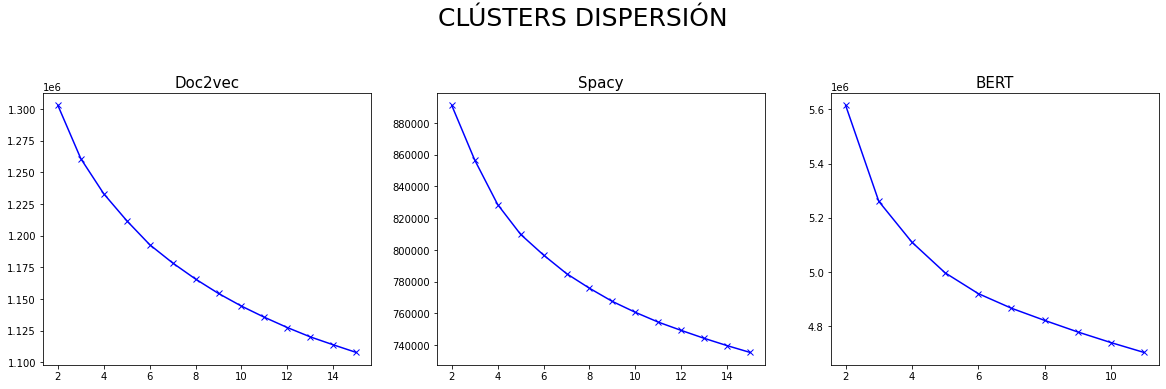

In [13]:
# Se establece la figura y los ejes
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,5)
fig.suptitle('CLÚSTERS DISPERSIÓN', fontsize=25, y=1.12)

ax[0].plot(range(2, 16), doc2vec_inertia, 'bx-')
ax[0].set_title('Doc2vec', fontsize = 15)

ax[1].plot(range(2, 16), spacy_inertia, 'bx-')
ax[1].set_title('Spacy', fontsize = 15)

ax[2].plot(range(2, 12), bert_inertia, 'bx-')
ax[2].set_title('BERT', fontsize = 15)

plt.savefig('clusters-optimos-dispersion.pdf')
plt.show()

Las curvas dibujadas se denominan curvas de codo y el objetivo es encontrar el punto donde la velocidad de reducción de la dispersión se reduce considerablemente. En los 3 corpus entrenados:

- Doc2vec: no parece que haya ningún punto donde se aprecie esa reducción significativamente.
- Spacy: parace que en los 3 clústers es donde más se aprecia dicha reducción, pero tampoco es muy considerable.
- BERT: en este caso si que se aprecia una reducción para 3 y 4 clústers.

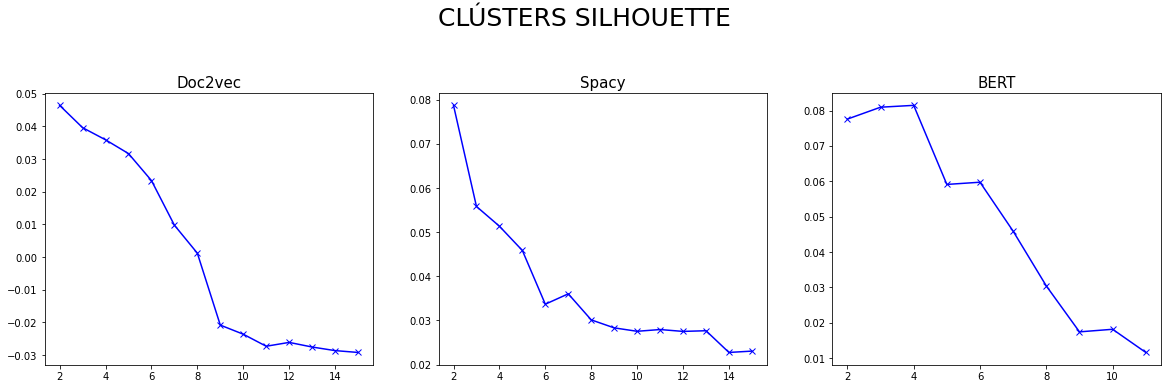

In [14]:
# Se establece la figura y los ejes
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,5)
fig.suptitle('CLÚSTERS SILHOUETTE', fontsize=25, y=1.12)

ax[0].plot(range(2, 16), doc2vec_silhouette_avgs, 'bx-')
ax[0].set_title('Doc2vec', fontsize = 15)

ax[1].plot(range(2, 16), spacy_silhouette_avgs, 'bx-')
ax[1].set_title('Spacy', fontsize = 15)

ax[2].plot(range(2, 12), bert_silhouette_avgs, 'bx-')
ax[2].set_title('BERT', fontsize = 15)

plt.savefig('clusters-optimos-silhouette.pdf')
plt.show()

En este segundo método el objetivo es encontrar un máximo en la gráfica que dará el número óptimo de clústers:

- Doc2vec: el máximo es 2.
- Spacy: el máximo es 2.
- BERT: en este caso el máximo es 4.

Viendo los resultados de ambas técnicas, parece que es difícil encontrar el número óptimo de clústers, lo que evvidencia que no parece que el corpus sea fácilmente divvidible en grupos. Se va a probar y analizar los siguientes modelos:

- Doc2vec: algoritmo con 2 y 3 clústers.
- Spacy: algoritmo con 2 y 3 clústers.
- BERT: algortimor con 3 y 4 clústers.

Se generan los modelos

In [12]:
doc2vec_corpus = np.loadtxt('doc2vec_corpus.csv', delimiter = ',')
spacy_corpus = np.loadtxt('spacy_corpus.csv', delimiter = ',')
bert_corpus = np.loadtxt('bert_corpus.csv', delimiter = ',')

In [16]:
model_2_cluster = KMeans(n_clusters=2, random_state = seed)
model_3_cluster = KMeans(n_clusters=3, random_state = seed)
model_4_cluster = KMeans(n_clusters=4, random_state = seed)

Se comienza por Doc2vec:

In [23]:
# Se entrena el modelo
doc2vec_model_2_cluster = model_2_cluster.fit(doc2vec_corpus)

# Se obtienen las prediciones
doc2vec_clusters_2 = doc2vec_model_2_cluster.fit_predict(doc2vec_corpus)

# Se guarda el modelo
pickle.dump(doc2vec_model_2_cluster, open("doc2vec_model_2_cluster.pkl", "wb"))

In [24]:
# Se entrena el modelo
doc2vec_model_3_cluster = model_3_cluster.fit(doc2vec_corpus)

# Se obtienen las prediciones
doc2vec_clusters_3 = doc2vec_model_3_cluster.fit_predict(doc2vec_corpus)

# Se guarda el modelo
pickle.dump(doc2vec_model_3_cluster, open("doc2vec_model_3_cluster.pkl", "wb"))

Se hace lo mismo para spacy:

In [25]:
# Se entrena el modelo
spacy_model_2_cluster = model_2_cluster.fit(spacy_corpus)

# Se obtienen las prediciones
spacy_clusters_2 = spacy_model_2_cluster.fit_predict(spacy_corpus)

# Se guarda el modelo
pickle.dump(spacy_model_2_cluster, open("spacy_model_2_cluster.pkl", "wb"))

In [17]:
# Se entrena el modelo
spacy_model_3_cluster = model_3_cluster.fit(spacy_corpus)

# Se obtienen las prediciones
spacy_clusters_3 = spacy_model_3_cluster.fit_predict(spacy_corpus)

# Se guarda el modelo
#pickle.dump(spacy_model_3_cluster, open("spacy_model_3_cluster.pkl", "wb"))

Por último, se entrenan los modelos para el corpus generado a travvés del algoritmo BERT:

In [28]:
# Se entrena el modelo
bert_model_3_cluster = model_3_cluster.fit(bert_corpus)

# Se obtienen las prediciones
bert_clusters_3 = bert_model_3_cluster.fit_predict(bert_corpus)

# Se guarda el modelo
pickle.dump(bert_model_3_cluster, open("bert_model_3_cluster.pkl", "wb"))

In [18]:
# Se entrena el modelo
bert_model_4_cluster = model_4_cluster.fit(bert_corpus)

# Se obtienen las prediciones
bert_clusters_4 = bert_model_4_cluster.fit_predict(bert_corpus)

# Se guarda el modelo
#pickle.dump(bert_model_4_cluster, open("bert_model_4_cluster.pkl", "wb"))

Se generan las columnas para el dataframe con los clusters

In [75]:
df['doc2vec-2-clusters'] = doc2vec_clusters_2
df['doc2vec-3-clusters'] = doc2vec_clusters_3
df['spacy-2-clusters'] = spacy_clusters_2
df['spacy-3-clusters'] = spacy_clusters_3
df['bert-3-clusters'] = bert_clusters_3
df['bert-4-clusters'] = bert_clusters_4

En primer lugar se quiere analizar para cada cluster en cada caso, los bigrams más comunes.

In [155]:
def get_most_common_bigrams_cluster(df, clusters, n_clusters):
    """
    Función generada para obtener los bigrams más comunes por clúster.
    
    param: df dataframe que contiene el texto y las columnas con los clústers
    param: clusters columna que contiene los clústers de los cuáles se quiere saber los bigrams más comunes
    param: n_clusters número de clústers
    
    :return: lista con los bigrams por clúster
    """
    
    most_common_bigrams_list = []
    
    for i in range(0,n_clusters):
        df_cluster = df[df[clusters]==i]
        cvec_bigram = CountVectorizer(ngram_range=(2,2), min_df = 150)
        bigrams = cvec_bigram.fit_transform(df_cluster['text'])
        count_bigrams = bigrams.toarray().sum(axis=0)
        vocab_bigram = cvec_bigram.vocabulary_
        count_bigrams_df = pd.DataFrame(sorted([(count_bigrams[i], k) for k,i in vocab_bigram.items()], 
                                        reverse=True)).rename(columns={0: 'FREQUENCY', 1:'BIGRAM'})
        count_bigrams_df = count_bigrams_df[:25]
        count_bigrams_df = count_bigrams_df[["BIGRAM", "FREQUENCY"]]

        most_common_bigrams_list.append(count_bigrams_df)

    return most_common_bigrams_list
    

In [156]:
doc2vec_2_most_common_bigrams = get_most_common_bigrams_cluster(df, 'doc2vec-2-clusters', 2)
doc2vec_3_most_common_bigrams = get_most_common_bigrams_cluster(df, 'doc2vec-3-clusters', 3)

spacy_2_most_common_bigrams = get_most_common_bigrams_cluster(df, 'spacy-2-clusters', 2)
spacy_3_most_common_bigrams = get_most_common_bigrams_cluster(df, 'spacy-3-clusters', 3)

bert_3_most_common_bigrams = get_most_common_bigrams_cluster(df, 'bert-3-clusters', 3)
bert_4_most_common_bigrams = get_most_common_bigrams_cluster(df, 'bert-4-clusters', 4)

A continuación se genera una función para imprimir por pantalla y guardar los resultados

In [228]:
def plot_most_common_bigrams(lista, title):
    
    """
    Función generada para guardar e imprimir los resultados de los bigrams.
    
    param: lista la lista que contiene los dataframes con los bigrams
    param: title el título de la visualziación, que se usará también como nombre para guardar dicha imagen
    """
    fig, ax = plt.subplots(1, len(lista))
    fig.set_size_inches(len(lista)*4,2)
    fig.suptitle(title, fontsize=15, y = 0.5)
    fig.patch.set_visible(False)

    for i in range(0, len(lista)):
        # Se esconden los ejes
        ax[i].axis('off')
        ax[i].axis('tight')

        # Se crean las tablas
        table = ax[i].table(cellText=lista[i].values, colLabels=lista[i].columns)
        table.set_fontsize(12)
        table.scale(1.25, 1.25)
    name = ('-').join(title.split()) + '.png'
    #plt.savefig(name)
    fig.tight_layout()
    plt.show()
        

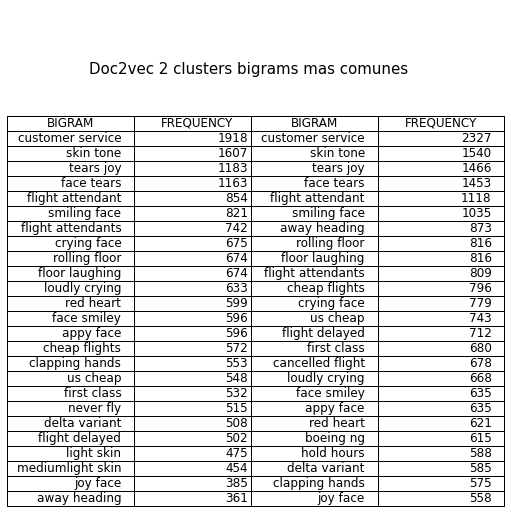

In [229]:
plot_most_common_bigrams(doc2vec_2_most_common_bigrams,'Doc2vec 2 clusters bigrams mas comunes')

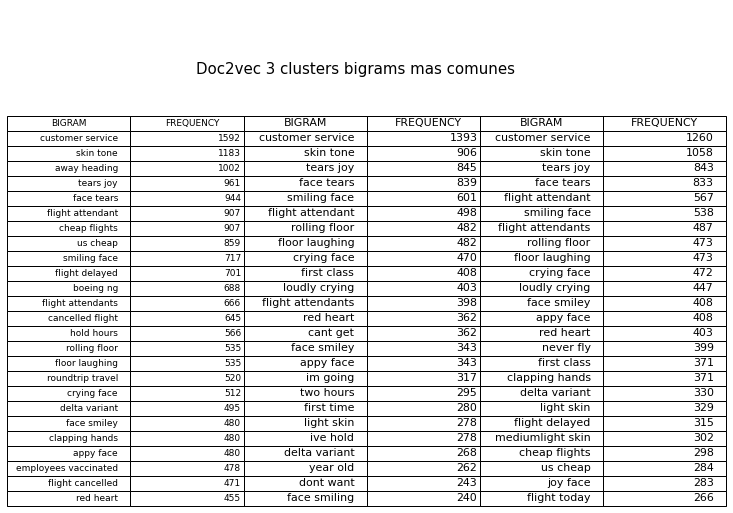

In [159]:
plot_most_common_bigrams(doc2vec_3_most_common_bigrams,'Doc2vec 3 clusters bigrams mas comunes')

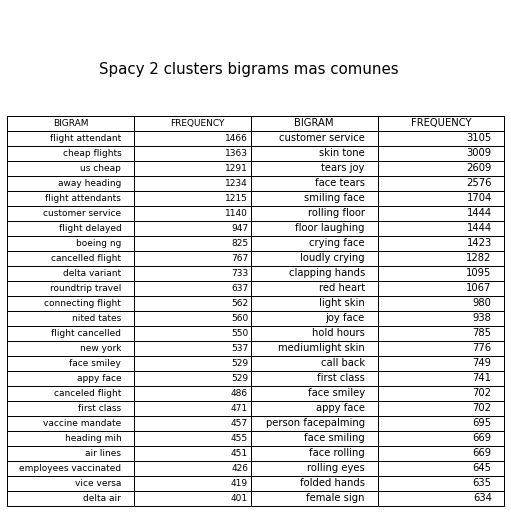

In [160]:
plot_most_common_bigrams(spacy_2_most_common_bigrams,'Spacy 2 clusters bigrams mas comunes')

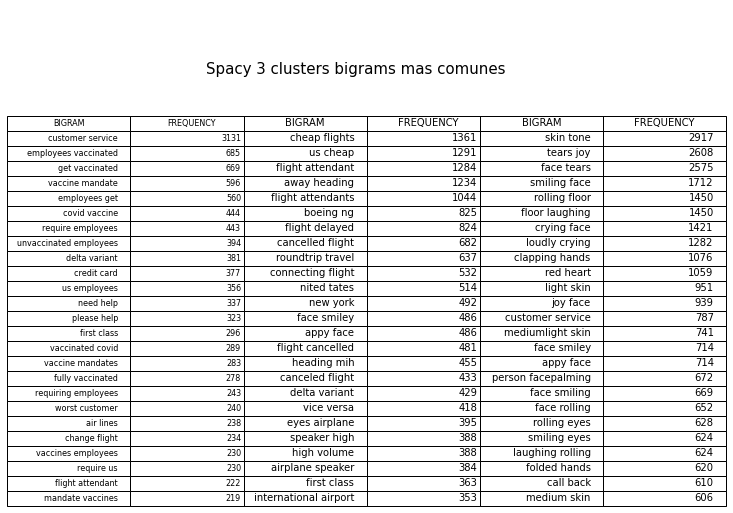

In [161]:
plot_most_common_bigrams(spacy_3_most_common_bigrams,'Spacy 3 clusters bigrams mas comunes')

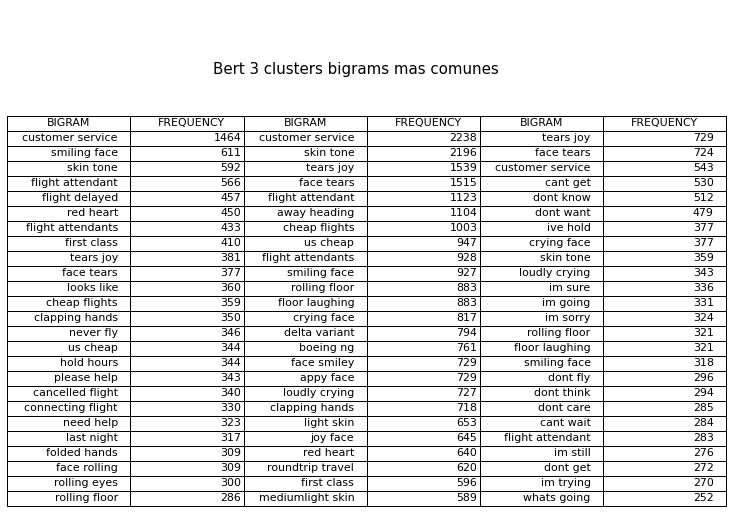

In [162]:
plot_most_common_bigrams(bert_3_most_common_bigrams,'Bert 3 clusters bigrams mas comunes')

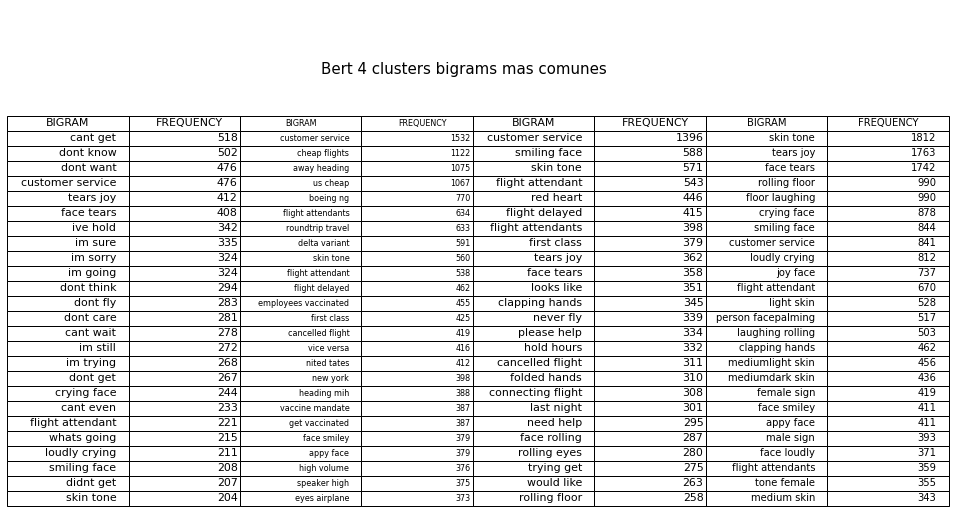

In [163]:
plot_most_common_bigrams(bert_4_most_common_bigrams,'Bert 4 clusters bigrams mas comunes')

Una vez se han obtenido los bigrams más comunes, también se quiere comprobar el sentimiento que se encuentra en cada clúster

In [218]:
def get_cluster_sentiment(df, clusters, n_clusters):
    """
    Función generada para obtener los vvalores de los sentimientos por cada clúster
    
    param: df dataframe que contiene el texto y las columnas con los clústers
    param: clusters columna que contiene los clústers de los cuáles se quiere saber los bigrams más comunes
    param: n_clusters número de clústers
    
    :return: lista con los bigrams por clúster
    """
    
    columns = ['Negativo', 'Neutral', 'Positivo', 'Sentimiento-Medio']
    rows = ['cluster-' + str(i) for i in list(range(0, n_clusters))]
    data = np.zeros((n_clusters, 4))
    for i in range(0,n_clusters):
        df_cluster = df[df[clusters]==i]
        values = list(df_cluster['vader-sentiment-analysis'].value_counts().sort_index().values) + [df_cluster['vader-sentiment'].mean()]
        data[i,:] = values      
    cluster_sentiment = pd.DataFrame(data, index = rows, columns=columns)
    name = clusters + '-sentiment.csv'
    cluster_sentiment.to_csv(name, index = True)
    return cluster_sentiment

In [219]:
doc2vec_2_sentiment = get_cluster_sentiment(df, 'doc2vec-2-clusters', 2)
doc2vec_3_sentiment = get_cluster_sentiment(df, 'doc2vec-3-clusters', 3)

spacy_2_sentiment = get_cluster_sentiment(df, 'spacy-2-clusters', 2)
spacy_3_sentiment = get_cluster_sentiment(df, 'spacy-3-clusters', 3)

bert_3_sentiment = get_cluster_sentiment(df, 'bert-3-clusters', 3)
bert_4_sentiment = get_cluster_sentiment(df, 'bert-4-clusters', 4)

In [220]:
doc2vec_2_sentiment

,Negativo,Neutral,Positivo,Sentimiento-Medio
cluster-0,26614.0,26769.0,41727.0,0.097901
cluster-1,31884.0,32263.0,42551.0,0.066646


In [221]:
doc2vec_3_sentiment

,Negativo,Neutral,Positivo,Sentimiento-Medio
cluster-0,23897.0,23410.0,30766.0,0.061365
cluster-1,16876.0,18258.0,24971.0,0.084177
cluster-2,17725.0,17364.0,28541.0,0.103284


In [222]:
spacy_2_sentiment

,Negativo,Neutral,Positivo,Sentimiento-Medio
cluster-0,21847.0,30561.0,26515.0,0.040184
cluster-1,36651.0,28471.0,57763.0,0.107832


In [223]:
spacy_3_sentiment

,Negativo,Neutral,Positivo,Sentimiento-Medio
cluster-0,16771.0,16907.0,24262.0,0.069906
cluster-1,14940.0,22171.0,17259.0,0.035074
cluster-2,26787.0,19954.0,42757.0,0.116931


In [224]:
bert_3_sentiment

,Negativo,Neutral,Positivo,Sentimiento-Medio
cluster-0,20637.0,18278.0,32587.0,0.104316
cluster-1,25661.0,30838.0,35850.0,0.071993
cluster-2,12200.0,9916.0,15841.0,0.060992


In [225]:
bert_4_sentiment

,Negativo,Neutral,Positivo,Sentimiento-Medio
cluster-0,10684.0,8521.0,13467.0,0.055109
cluster-1,16174.0,22956.0,22063.0,0.061570
cluster-2,19689.0,16967.0,31176.0,0.106449
cluster-3,11951.0,10588.0,17572.0,0.090587


Analizando los resultados obtenidos con los bigrams más comununes y el sentimiento medio se puede concluir que los datos obtenidos de los clústeres de 2 grupos no aportan gran información, por lo que se pueden excluir. En cuanto al resto:

- El modelo de 3 clústeres sobre el vector obtenido a través de Doc2vec no aporta apenas ningún valor y se observa como los témrinos más feecuentes se repiten constantemente en todos los clústeres.

- El modelo de 3 clústeres sobre el vector obtenido a través de Spacy sí que aporta un valor añadido. Se pueden observar 3 clústeres cuyos términos están muy diferenciados. El primero parece que tiene como tema principal las vacunas, el segundo en cambio parece incluir términos relacionados con asistentes de vuelo, cancelaciones retraso etc. Por último, en el tercer clúster, todos los términos más comunes hacen referencia a los emoticonos, por lo que parece incluir todos los tweets con emoticonos. En cuanto al sentimiento, tiene sentido que el segundo clúster tenga el sentimiento más bajo ya que trata sobre cancelacions y retrasos de vuelos, mientras que el último, que contiene los tweets con emoticonos, es el que tiene un sentimiento más positivo, por lo que parece que el uso de emojis/emoticonos es en su mayoría positivo.

- En cuanto a los modelos sobre el vector obtenido a través de BERT, centrándonos en el de 4 clúster, el segundo de ellos parece incluir términos más relacionados con el vuelo, mientras que el resto son difíciles de analziar.

En definitiva parece que es muy difícil encontrar clústeres bien definidos a partir de los tweets.

A continuación se van a visualizar nuevamente los corpus obtenidos a través de Spacy y de BERT diferenciando los clústeres seleccionados.

En primer lugar se hace una pequeña modificación para variar el nombre de los clústers

In [54]:
df['spacy-3-clusters'] = spacy_clusters_3
spacy_map_dict = {0:'Cluster-0', 1:'Cluster-1', 2:'Cluster-2'}
df['spacy-3-clusters'] = df['spacy-3-clusters'].map(spacy_map_dict)

df['bert-4-clusters'] = bert_clusters_4
bert_map_dict = {0:'Cluster-0', 1:'Cluster-1', 2:'Cluster-2', 3:'Cluster-3'}
df['bert-4-clusters'] = df['bert-4-clusters'].map(bert_map_dict)

Se genera la reducción de dimensionalidad para spacy

In [28]:
umap_df_spacy_dup = umap_function([5], [0.1], 'euclidean', seed, spacy_corpus)
umap_df_spacy_dup['texto']=df['text']
umap_df_spacy_dup['sentimiento']=df['vader-sentiment-analysis']
umap_df_spacy_dup['cluster']=df['spacy-3-clusters']

5


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Se genera el gráfico para spacy

In [52]:
# Se genera el gráfico con todas las visualizaciones
chart_spacy = alt.Chart(umap_df_spacy_dup).mark_circle(size=20).encode(
    x=alt.X('X'),
    y=alt.Y('Y'),
    color=alt.Color('cluster',
                   scale=alt.Scale(
            domain=['Cluster-0', 'Cluster-1', 'Cluster-2'],
            range=['#3d6b64', '#d48b3d', '#8e2414'])),
    tooltip=['texto', 'sentimiento']
).properties(
    width=1200, height=600, title = "Visualización de embeddings"
).interactive()

chart_spacy.save('spacy_reduccion_dimensionalidad_cluster.html')

Se hace lo propio con BERT

In [53]:
umap_df_bert_dup = umap_function([5], [0.05], 'euclidean', seed, bert_corpus)
umap_df_bert_dup['texto']=df['text']
umap_df_bert_dup['sentimiento']=df['vader-sentiment-analysis']
umap_df_bert_dup['cluster']=df['bert-4-clusters']

5


In [55]:
# Se genera el gráfico con todas las visualizaciones
chart_bert = alt.Chart(umap_df_bert_dup).mark_circle(size=20).encode(
    x=alt.X('X'),
    y=alt.Y('Y'),
    color=alt.Color('cluster',
                   scale=alt.Scale(
            domain=['Cluster-0', 'Cluster-1', 'Cluster-2', 'Cluster-3'],
            range=['#3d6b64', '#d48b3d', '#8e2414', '#4682b4'])),
    tooltip=['texto', 'sentimiento']
).properties(
    width=1200, height=600, title = "Visualización de embeddings"
).interactive()

chart_bert.save('bert_reduccion_dimensionalidad_cluster.html')

Analizando las imágenes, sí que se aprecia comoo los clústeres se observan bien diferenciados en las imágenes, pero como se ha comentado, es difícil extraer conclusiones acerca de estos clústeres con la información que ha sido obtenida.

### Referencias

- Topic Model Visualization using pyLDAvis: https://towardsdatascience.com/topic-model-visualization-using-pyldavis-fecd7c18fbf6
- Word Embeddings in Python with Spacy and Gensim: https://www.shanelynn.ie/word-embeddings-in-python-with-spacy-and-gensim/
- pyLDAvis documentation: https://pyldavis.readthedocs.io/en/latest/modules/API.html
- Doc2vec documentation: https://radimrehurek.com/gensim/models/doc2vec.html
- A Visual Guide to Using BERT for the First Time: https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
- Devlin, J., Chang, M., Lee, K., & Toutanova, K. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. NAACL. https://www.semanticscholar.org/paper/BERT%3A-Pre-training-of-Deep-Bidirectional-for-Devlin-Chang/df2b0e26d0599ce3e70df8a9da02e51594e0e992
- Transformers Documentation: https://huggingface.co/transformers/
- UMAP Documentation: https://umap-learn.readthedocs.io/en/latest/index.html
- McInnes, Leland & Healy, John. (2018). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. https://www.researchgate.net/publication/323141395_UMAP_Uniform_Manifold_Approximation_and_Projection_for_Dimension_Reduction



In [21]:
spacy_clusters_3

array([2, 1, 1, ..., 0, 0, 2], dtype=int32)